In [25]:


import os
import numpy as np
import cv2
from tqdm import tqdm
from pycocotools.coco import COCO
from PIL import Image


ANNOTATION_FILE = "/content/annotations/annotations/instances_val2017.json"
IMAGE_DIR = "/content/val2017/val2017"
OUTPUT_BINARY_MASK_DIR = "processed/binary_masks"
os.makedirs(OUTPUT_BINARY_MASK_DIR, exist_ok=True)


coco = COCO(ANNOTATION_FILE)
img_ids = coco.getImgIds()

def create_main_subject_mask(coco, img_id, img_shape, focus_category=None):
    """
    focus_category: Optional — specify category name to focus on (e.g., 'person')
    If None, it takes the largest object in the image as the main subject.
    """
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)


    if not anns:
        return np.zeros(img_shape[:2], dtype=np.uint8)


    if focus_category:
        cat_ids = coco.getCatIds(catNms=[focus_category])
        anns = [a for a in anns if a["category_id"] in cat_ids]


    if not anns:
        return np.zeros(img_shape[:2], dtype=np.uint8)
    largest_ann = max(anns, key=lambda x: x["area"])
    mask = coco.annToMask(largest_ann).astype(np.uint8)

    return mask


print("🔹 Generating binary masks (main subject only)...")

for img_id in tqdm(img_ids[:500]):
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(IMAGE_DIR, img_info["file_name"])
    if not os.path.exists(img_path):
        continue


    img = np.array(Image.open(img_path).convert("RGB"))
    mask = create_main_subject_mask(coco, img_id, img.shape, focus_category=None)  # or focus_category="person"


    out_name = os.path.splitext(img_info["file_name"])[0]
    out_path = os.path.join(OUTPUT_BINARY_MASK_DIR, f"{out_name}.png")
    cv2.imwrite(out_path, mask * 255)

print(f"✅ Saved binary masks to '{OUTPUT_BINARY_MASK_DIR}' successfully!")


loading annotations into memory...
Done (t=0.94s)
creating index...
index created!
🔹 Generating binary masks (main subject only)...


100%|██████████| 500/500 [00:04<00:00, 109.01it/s]

✅ Saved binary masks to 'processed/binary_masks' successfully!


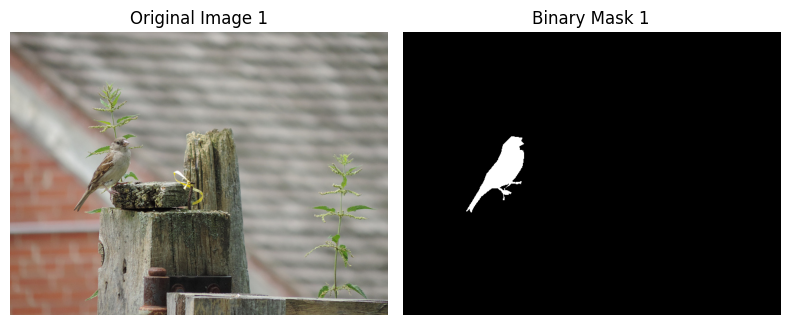

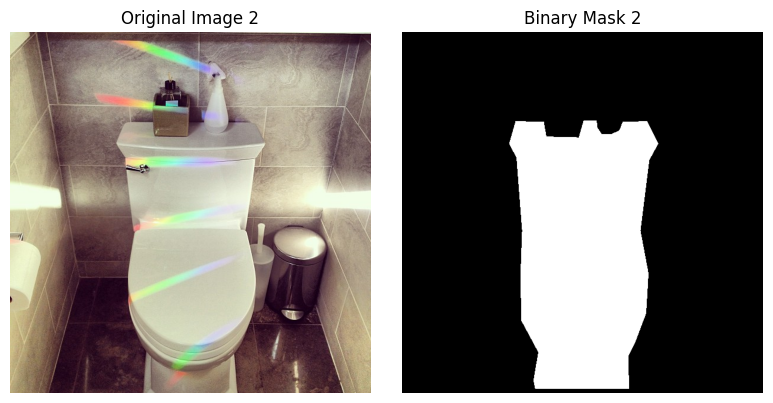

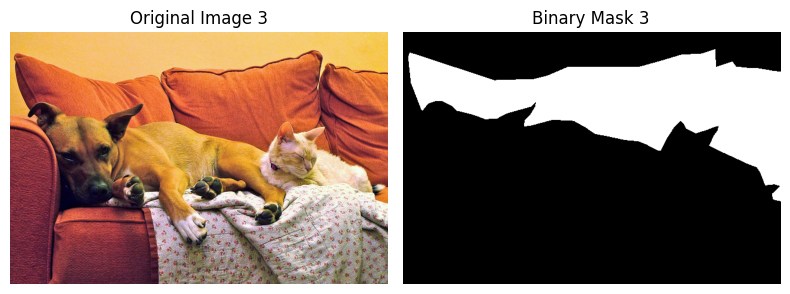

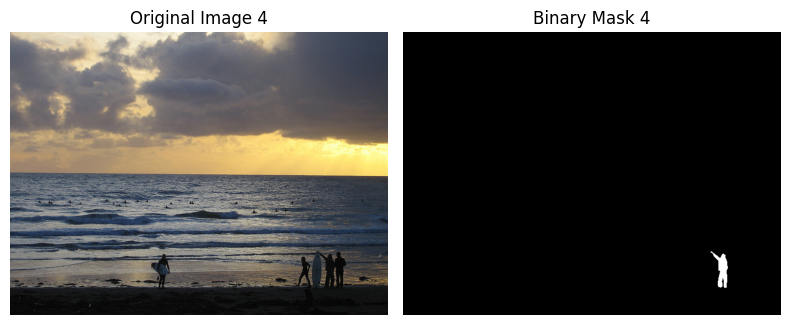

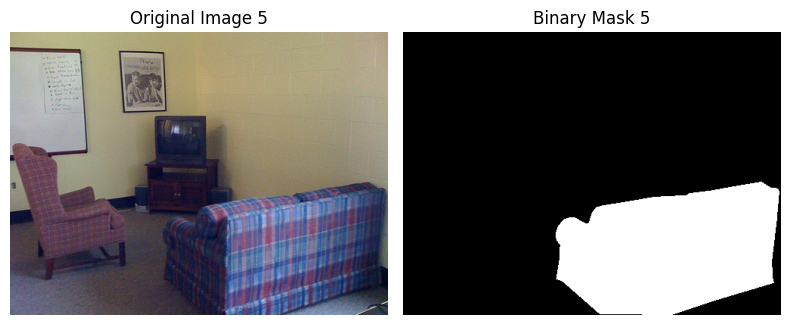

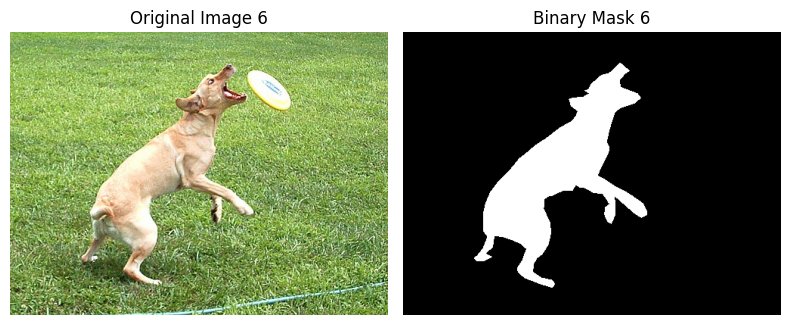

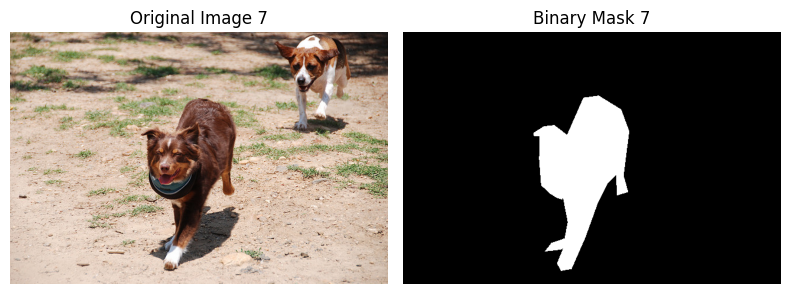

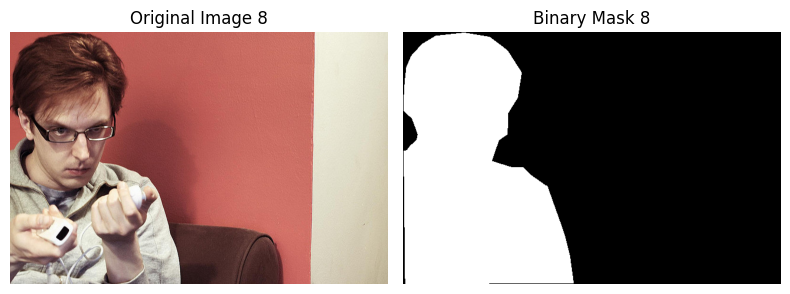

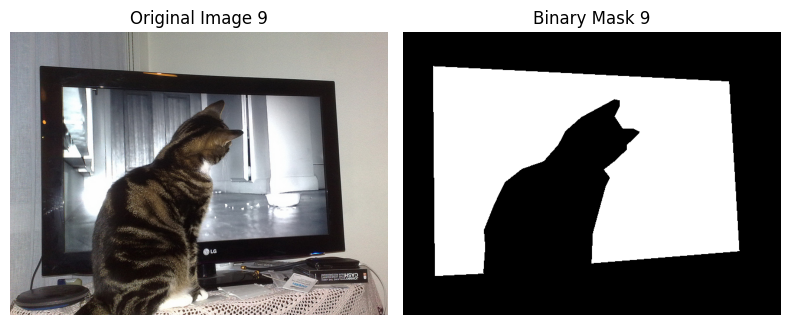

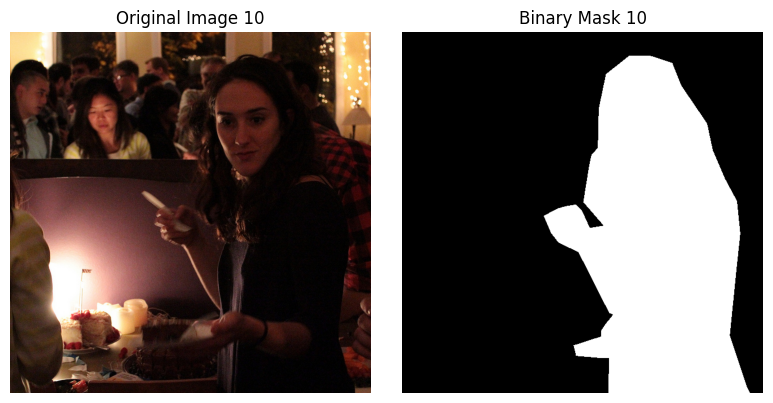

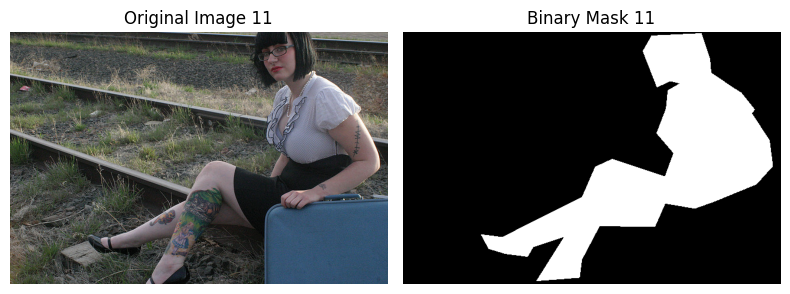

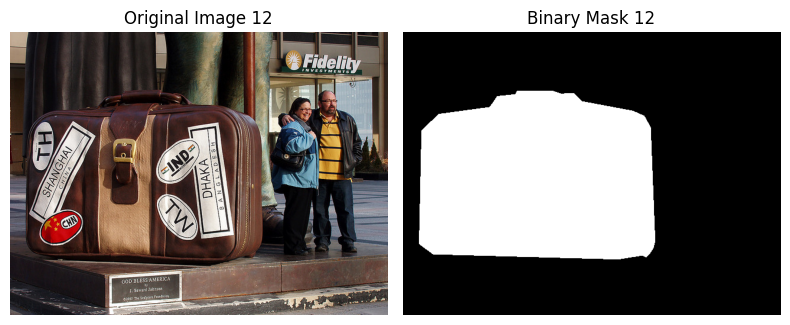

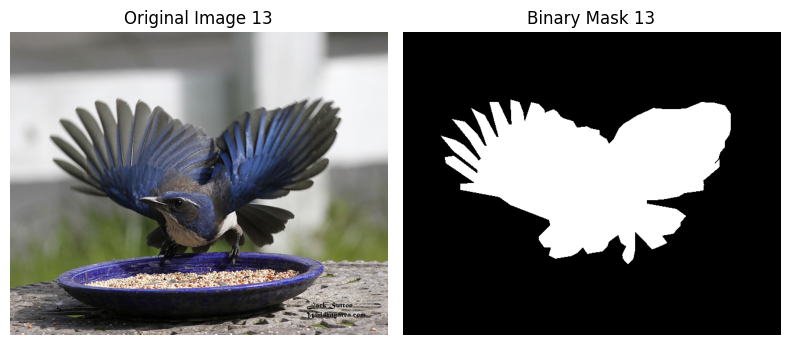

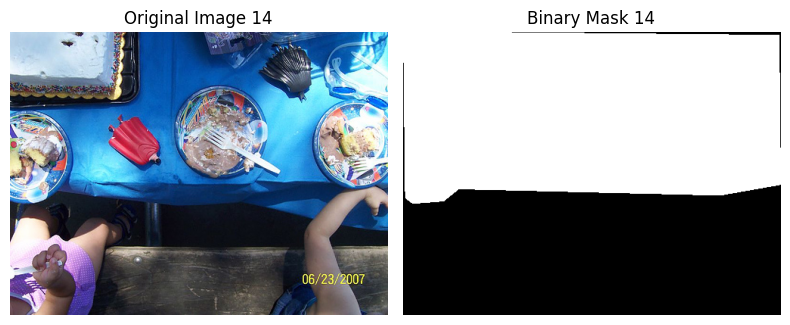

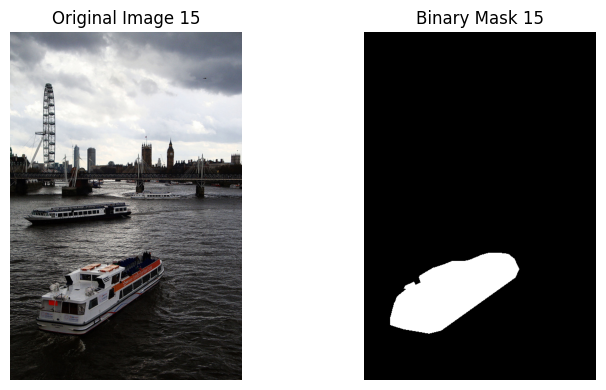

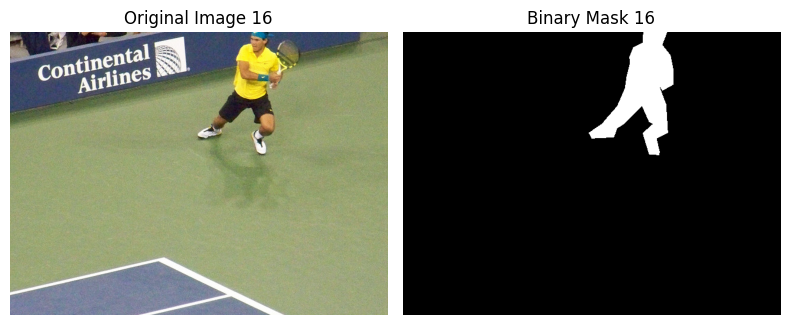

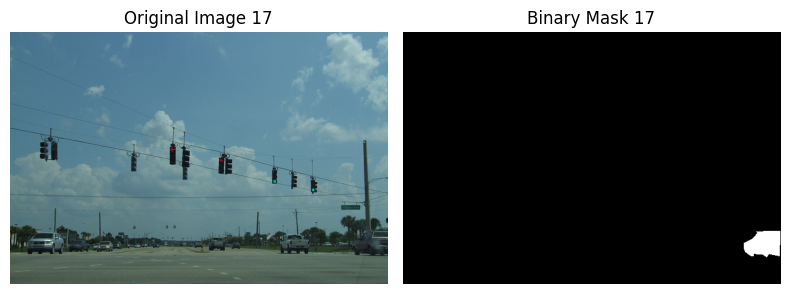

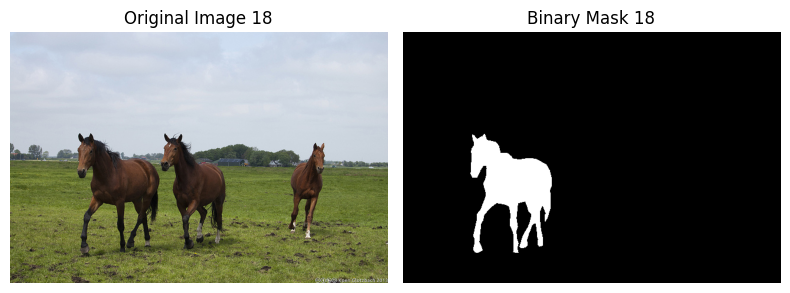

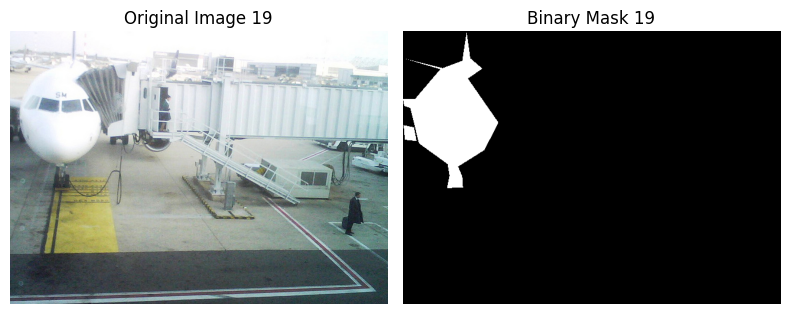

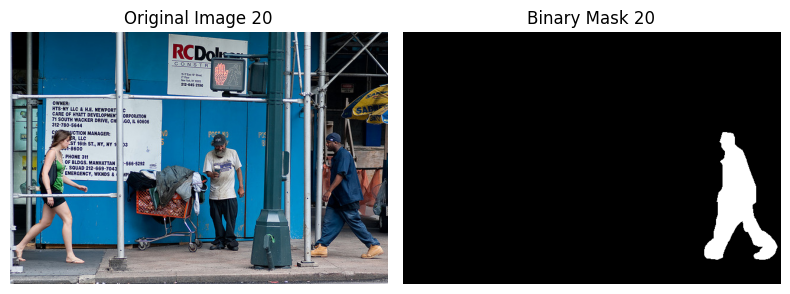

In [ ]:


import matplotlib.pyplot as plt
import cv2
import os
import random
from PIL import Image


IMAGE_DIR = "/content/val2017/val2017"
BINARY_MASK_DIR = "processed/binary_masks"


samples = random.sample(os.listdir(BINARY_MASK_DIR), 20)

# Display
for i, fname in enumerate(samples, 1):
    mask_path = os.path.join(BINARY_MASK_DIR, fname)
    img_path = os.path.join(IMAGE_DIR, fname.replace(".png", ".jpg"))

    if not os.path.exists(img_path):
        continue

    # Load both image and mask
    img = np.array(Image.open(img_path).convert("RGB"))
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Plot side by side
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(img)
    ax[0].set_title(f"Original Image {i}")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title(f"Binary Mask {i}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()
